In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

%matplotlib inline

In [2]:
file_path = Path("all_features.csv")
combined_df = pd.read_csv(file_path, infer_datetime_format = True, parse_dates = True, index_col = "date_time")
combined_df.sort_index(inplace=True)

In [3]:
#combined_df['target_price'] = combined_df['close'].shift(-1)
combined_df['target_return'] = combined_df['return'].shift(-1)
combined_df = combined_df.dropna()

In [4]:
combined_df

,close,vol,spy,return,Beta,WR,RSI,OBV,sentiment_vader,sentiment_rnn,us2y10y,vix,usdjpy,target_return
date_time,,,,,,,,,,,,,,
2021-01-28 09:30:00,12.8550,13613460,376.500,-0.353208,-16.037653,0.000000,21.118340,43234860.0,-1.0,-1.0,91.536,30.21,104.36,0.054065
2021-01-28 09:31:00,13.5500,968001,376.780,0.054065,-15.464347,-100.000000,26.473885,44202861.0,1.0,1.0,91.536,30.17,104.33,0.000000
2021-01-28 09:32:00,13.5500,968001,376.760,0.000000,-15.409797,-90.099715,24.653967,45170862.0,0.0,0.0,91.536,30.24,104.31,0.000000
2021-01-28 09:33:00,13.5500,968001,377.040,0.000000,-15.310284,-90.099715,23.518120,46138863.0,0.0,0.0,91.706,29.96,104.30,0.000000
2021-01-28 09:34:00,13.5500,968001,376.830,0.000000,-15.296337,-90.099715,22.740886,47106864.0,0.0,0.0,91.875,29.75,104.31,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-31 15:54:00,10.1780,242191,396.600,-0.000363,2.186897,-26.600000,49.261448,300643273.0,0.0,0.0,157.321,18.89,110.75,-0.001769
2021-03-31 15:55:00,10.1600,101166,396.345,-0.001769,2.227686,-34.000000,43.296272,300542107.0,0.0,0.0,157.142,19.01,110.73,0.005896
2021-03-31 15:56:00,10.2199,308278,396.520,0.005896,2.453740,-79.973298,60.829715,300850385.0,0.0,0.0,156.964,18.99,110.73,0.000499


In [5]:
X = combined_df[['return', 'Beta', 'WR', 'RSI', 'OBV', 'sentiment_vader', 'sentiment_rnn', 'us2y10y', 'vix', 'usdjpy']]

In [6]:
target = combined_df.iloc[:,13]
y = target.values.reshape(-1, 1)

In [7]:
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [8]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [9]:
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.ensemble import GradientBoostingRegressor

xgb = GradientBoostingRegressor(random_state=0, loss='ls')

param_distributions = {"max_depth": [3, 5, 10],
                        "learning_rate": [0.01, 0.1, 0.5, 0.75],
                       #"n_estimators": [10, 100, 1000]
                      }

search = HalvingRandomSearchCV(xgb, param_distributions,
                               resource = "n_estimators",
                               max_resources=12,
                               random_state=0).fit(X_train, y_train.ravel())

In [10]:
search.best_params_

{'max_depth': 3, 'learning_rate': 0.01, 'n_estimators': 9}

In [11]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.75,
        max_depth=5, random_state=0, loss='ls')

In [12]:
from sklearn.ensemble import AdaBoostRegressor
ada = AdaBoostRegressor(random_state=0, n_estimators=1000, learning_rate = 0.75)

In [13]:
model.fit(X_train, y_train.ravel())

GradientBoostingRegressor(learning_rate=0.75, max_depth=5, n_estimators=1000,
                          random_state=0)

In [14]:
y_pred = model.predict(X_test)

In [15]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

0.00277203044913624

In [16]:
model.score(X_test, y_test)

-142.5951787694426

In [17]:
predicted_value = scaler.inverse_transform(y_pred.reshape(-1,1))
real_value = scaler.inverse_transform(y_test)

In [18]:
output = pd.DataFrame({
    "Real": real_value.ravel(),
    "Predicted": predicted_value.ravel()
    }, index = combined_df.index[-len(real_value): ])
output.head()

,Real,Predicted
date_time,,
2021-03-12 14:41:00,-0.002116,0.002374
2021-03-12 14:42:00,-0.001907,0.000845
2021-03-12 14:43:00,-0.000250,0.002712
2021-03-12 14:44:00,-0.001518,0.002914
2021-03-12 14:45:00,0.002531,-0.005444


<AxesSubplot:xlabel='date_time'>

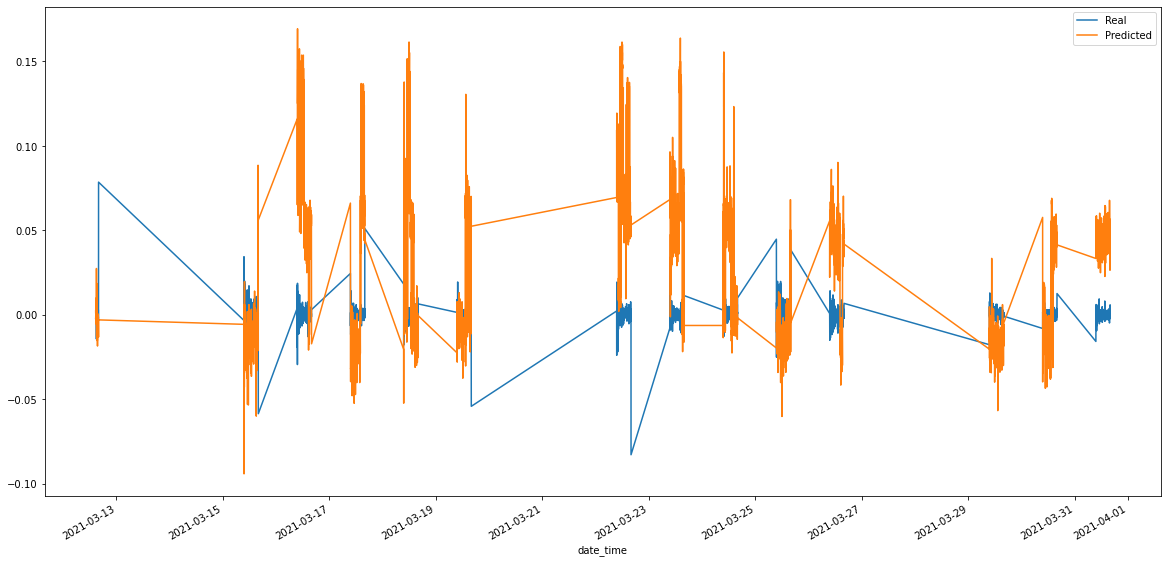

In [19]:
output.plot(figsize = (20,10))

In [20]:
model.feature_importances_ * 100

array([10.82830242,  8.6549933 ,  5.6972343 ,  9.53208269,  8.26998602,
        2.47771489,  1.61350123, 14.88649625, 31.35620599,  6.68348292])

In [21]:
output

,Real,Predicted
date_time,,
2021-03-12 14:41:00,-0.002116,0.002374
2021-03-12 14:42:00,-0.001907,0.000845
2021-03-12 14:43:00,-0.000250,0.002712
2021-03-12 14:44:00,-0.001518,0.002914
2021-03-12 14:45:00,0.002531,-0.005444
...,...,...
2021-03-31 15:54:00,-0.001769,0.043170
2021-03-31 15:55:00,0.005896,0.046270
2021-03-31 15:56:00,0.000499,0.056596


In [22]:
output.describe()

,Real,Predicted
count,5148.000000,5148.000000
mean,-0.000009,0.027909
std,0.004449,0.045083
min,-0.082864,-0.094183
25%,-0.001629,-0.011448
50%,0.000000,0.032288
75%,0.001603,0.056306
max,0.078546,0.169367


In [23]:
output.sum()

Real          -0.045556
Predicted    143.673332
dtype: float64

In [24]:
final_output = output.join(combined_df[['close']])
final_output.to_csv("predictions.csv")